# Analysis of results from transient-outward Potassium channel ABC calibration

This notebook compares the behaviour of the $I_\text{to}$ current in Nygren, Courtemanche and standardised formulations.

In [108]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from pyabc import History
from pyabc.weighted_statistics import weighted_mean, weighted_median

from ionchannelABC.visualization import plot_variables
from ionchannelABC.utils import weighted_cv

## Load pyABC results databases for each run

Assumes that the results databases are stored in a subdirectory called `results'.

Loads history files and converts to dataframes and weights (see pyABC documentation).

#### Nygren

In [4]:
h_nyg_original = History('sqlite:///results/nygren/ito/original/nygren_ito_original.db')
h_nyg_unified = History('sqlite:///results/nygren/ito/unified/nygren_ito_unified.db')

In [5]:
df_nyg_original, w_nyg_original = h_nyg_original.get_distribution(m=0)
df_nyg_unified, w_nyg_unified = h_nyg_unified.get_distribution(m=0)

#### Courtemanche

In [6]:
# COU uses same original and unified datasets
h_cou_a_original = History('sqlite:///results/courtemanche/ito/original/courtemanche_ito_agate_original.db')
h_cou_i_original = History('sqlite:///results/courtemanche/ito/original/courtemanche_ito_igate_original.db')

In [7]:
df_cou_a_original, w_cou_a_original = h_cou_a_original.get_distribution(m=0)
df_cou_i_original, w_cou_i_original = h_cou_i_original.get_distribution(m=0)

#### Standardised

In [8]:
h_sta = History('sqlite:///results/standardised/ito/standardised_ito.db')

In [9]:
df_sta, w_sta = h_sta.get_distribution(m=0)

## Compare number of gating parameters in models

Generate bar plot using manually input numbers. See models and publications for source.

In [10]:
data = [['N',5,6],['C',10,8],['S',4,4]]

In [11]:
df = pd.DataFrame(data, columns = ['model', 'act', 'inact'])

In [12]:
df.inact = df.act+df.inact

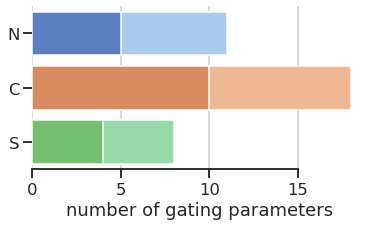

In [13]:
sns.set(style="ticks")
sns.set_context('talk')
sns.set_color_codes("pastel")

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plt.subplots(figsize=(6,3))

sns.barplot(x="inact", y="model", hue="model", data=df,
            palette="pastel", dodge=False)
            #label="inact", color="b")

sns.set_color_codes("muted")
sns.barplot(x="act", y="model", hue="model", data=df,
            palette="muted", dodge=False)
            #label="act", color="r")

handles, labels = ax.get_legend_handles_labels()
order = []
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
          ncol=2, loc="lower right", frameon=False)
ax.set(xlabel="number of gating parameters")
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

In [14]:
#f.savefig('figures/ito/param_num_compare.pdf')

## Compare calibration between original and unified datasets

Plot relative standard deviation (RSD) of parameter posteriors and gating functions for Nygren and Courtemanche using the original dataset and unified datasets.

Note: we use the term RSD instead of CV (coefficient of variation) to avoid confusion with conduction velocity.

#### Calculate RSD values for Nygren and Courtemanche models

In [15]:
rsd_nyg_original = weighted_cv(df_nyg_original, w_nyg_original, sample_size=len(df_nyg_original))
model = ['N',]*len(rsd_nyg_original)
data = ['ORIGINAL',]*len(rsd_nyg_original)
frame = {'model': model, 'data': data, 'RSD': rsd_nyg_original}
nyg_original = pd.DataFrame(frame)

In [17]:
rsd_nyg_unified = weighted_cv(df_nyg_unified, w_nyg_unified, sample_size=len(df_nyg_unified))
model = ['N',]*len(rsd_nyg_unified)
data = ['UNIFIED',]*len(rsd_nyg_unified)
frame = {'model': model, 'data': data, 'RSD': rsd_nyg_unified}
nyg_unified = pd.DataFrame(frame)

In [23]:
rsd_cou_a_original = weighted_cv(df_cou_a_original, w_cou_a_original, sample_size=len(df_cou_a_original))
rsd_cou_i_original = weighted_cv(df_cou_i_original, w_cou_i_original, sample_size=len(df_cou_i_original))

rsd_cou_original = pd.concat([rsd_cou_a_original, rsd_cou_i_original])
model = ['C',]*len(rsd_cou_original)
data = ['ORIGINAL',]*len(rsd_cou_original)
frame = {'model': model, 'data': data, 'RSD': rsd_cou_original}
cou_original = pd.DataFrame(frame)

In [35]:
rsd_cou_unified = pd.concat([rsd_cou_a_original, rsd_cou_i_original])
model = ['C',]*len(rsd_cou_unified)
data = ['UNIFIED',]*len(rsd_cou_unified)
frame = {'model': model, 'data': data, 'RSD': rsd_cou_unified}
cou_unified = pd.DataFrame(frame)

In [36]:
rsd_compare = pd.concat([nyg_original, nyg_unified, cou_original, cou_unified], sort=False)

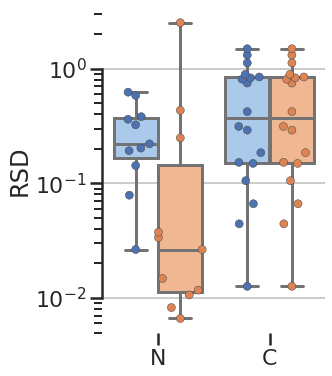

In [37]:
sns.set(style="ticks")
sns.set_context("poster")

# Initialize the figure
f, ax = plt.subplots(figsize=(4, 6))

# Plot the boxplot summary of RSD
sns.boxplot(x="model", y="RSD", hue="data", data=rsd_compare,
            palette="pastel", whis="range")

# Add in points to show each observation
sns.swarmplot(x="model", y="RSD", hue="data", data=rsd_compare,
              linewidth=0.5, size=8, dodge=True)

# Tweak the visual presentation
ax.yaxis.grid(True)
ax.set(ylabel="RSD")
ax.set_yscale('log')
ax.set(xlabel="")
sns.despine(trim=True, bottom=True)
ax.get_legend().remove()

In [38]:
diff = nyg_unified.RSD-nyg_original.RSD
stats.wilcoxon(diff)

WilcoxonResult(statistic=18.0, pvalue=0.18231443298387762)

In [40]:
#f.savefig('figures/ito/rsd_compare.pdf')

#### Compare underlying gating functions for each model

Sample from posterior particle population and plot resulting gating functions

In [42]:
N = 100

In [43]:
nyg_par_samples_original = df_nyg_original.sample(n=N, weights=w_nyg_original, replace=True)
nyg_par_samples_original = nyg_par_samples_original.set_index([pd.Index(range(N))])
nyg_par_samples_original = nyg_par_samples_original.to_dict(orient='records')

In [44]:
nyg_par_samples_unified = df_nyg_unified.sample(n=N, weights=w_nyg_unified, replace=True)
nyg_par_samples_unified = nyg_par_samples_unified.set_index([pd.Index(range(N))])
nyg_par_samples_unified = nyg_par_samples_unified.to_dict(orient='records')

In [45]:
v = np.arange(-100, 50, 0.5)

nyg_par_map = {'ri': 'ito.r_inf',
               'rt': 'ito.tau_r',
               'si': 'ito.s_inf',
               'st': 'ito.tau_s'}

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


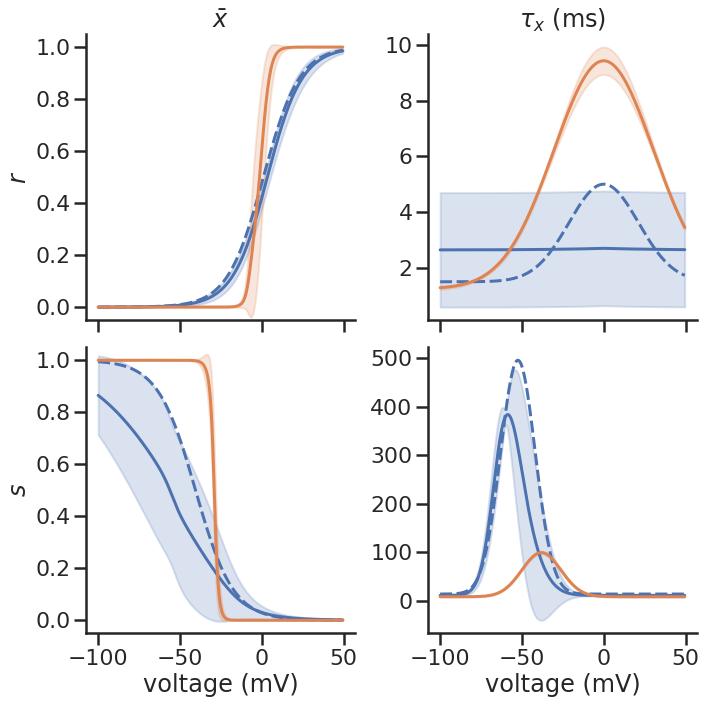

In [47]:
sns.set_context('poster')
sns.set_palette('deep')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14


f, ax = plot_variables(v, [nyg_par_map, nyg_par_map], 
                       ['models/nygren_ito.mmt', 'models/nygren_ito_.mmt'], 
                       [nyg_par_samples_original, nyg_par_samples_unified],
                       original=[True,False],
                       figshape=(2,2))

ax[0][0].set_ylabel(r'$r$')
ax[1][0].set_ylabel(r'$s$')

ax[0][0].set_title(r'$\bar{x}$')
ax[0][1].set_title(r'$\tau_x$ (ms)')

for a in ax[:,1].flatten():
    a.set_ylabel('')
    
for a in ax[1][:]:
    a.set_xlabel('voltage (mV)')

for a in ax[:,0]:
    a.set_ylim((-0.05, 1.05))
    
plt.tight_layout()

In [48]:
#f.savefig('figures/ito/nyg_gating_functions.pdf')

In [49]:
cou_par_samples_a_original = df_cou_a_original.sample(n=N, weights=w_cou_a_original, replace=True)
cou_par_samples_a_original = cou_par_samples_a_original.set_index([pd.Index(range(N))])
cou_par_samples_i_original = df_cou_i_original.sample(n=N, weights=w_cou_i_original, replace=True)
cou_par_samples_i_original = cou_par_samples_i_original.set_index([pd.Index(range(N))])
cou_par_samples = (pd.concat([cou_par_samples_a_original,
                              cou_par_samples_i_original],axis=1)
                   .to_dict(orient='records'))

In [50]:
cou_par_map = {'ri': 'ito.a_inf',
               'rt': 'ito.tau_a',
               'si': 'ito.i_inf',
               'st': 'ito.tau_i'}

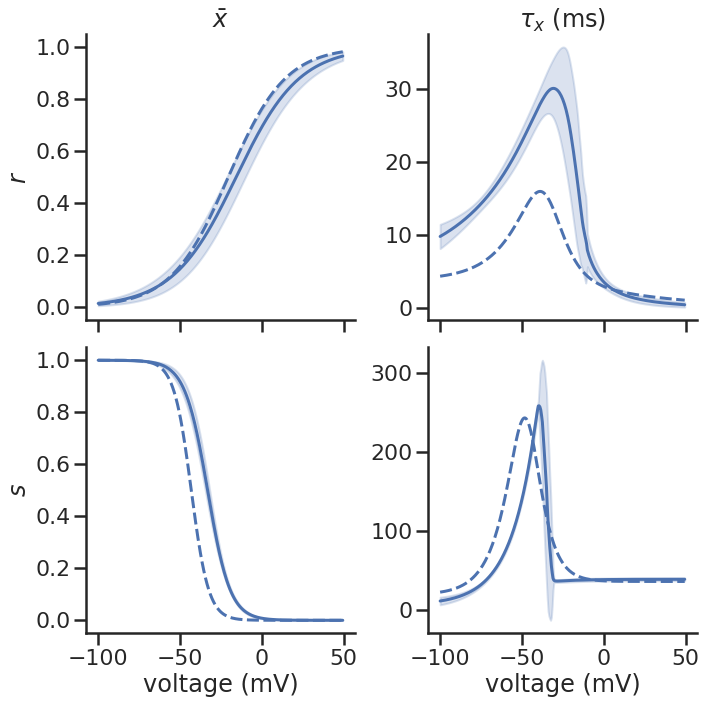

In [51]:
from ionchannelABC.visualization import plot_variables
sns.set_context('poster')
sns.set_palette('deep')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14


f, ax = plot_variables(v, [cou_par_map], 
                       ['models/courtemanche_ito.mmt'], 
                       [cou_par_samples],
                       original=[True,False],
                       figshape=(2,2))

ax[0][0].set_ylabel(r'$r$')
ax[1][0].set_ylabel(r'$s$')

ax[0][0].set_title(r'$\bar{x}$')
ax[0][1].set_title(r'$\tau_x$ (ms)')

for a in ax[:,1].flatten():
    a.set_ylabel('')
    
for a in ax[1][:]:
    a.set_xlabel('voltage (mV)')

for a in ax[:,0]:
    a.set_ylim((-0.05, 1.05))
    
plt.tight_layout()

In [52]:
#f.savefig('figures/ito/cou_gating_functions.pdf')

## Compare all models calibrated to unified dataset

### RSD of parameter posteriors

In [53]:
rsd_sta = weighted_cv(df_sta, w_sta, sample_size=len(df_sta))
model = ['S',]*len(rsd_sta)
frame = {'model': model, 'RSD': rsd_sta}
sta = pd.DataFrame(frame)

In [54]:
rsd_unified = pd.concat([nyg_unified, cou_unified, sta], sort=False)

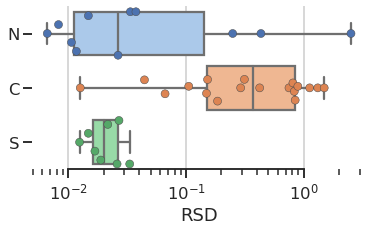

In [55]:
sns.set(style="ticks")
sns.set_context('talk')

# Initialize the figure
f, ax = plt.subplots(figsize=(6, 3))

sns.boxplot(x="RSD", y="model", data=rsd_unified,
            palette="pastel", whis="range")

# Add in points to show each observation
sns.swarmplot(x="RSD", y="model", data=rsd_unified,
              linewidth=0.5, size=8, dodge=True)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(xlabel="RSD")
ax.set_xscale("log")
ax.set(ylabel="")
sns.despine(trim=True, left=True)

In [56]:
#f.savefig('figures/ito/rsd_compare_unified.pdf')

In [58]:
stats.mannwhitneyu(rsd_unified[rsd_unified.model=='N'].RSD, 
                   rsd_unified[rsd_unified.model=='S'].RSD)

MannwhitneyuResult(statistic=40.0, pvalue=0.3862895453617557)

In [59]:
stats.mannwhitneyu(rsd_unified[rsd_unified.model=='C'].RSD, 
                   rsd_unified[rsd_unified.model=='S'].RSD)

MannwhitneyuResult(statistic=7.0, pvalue=0.00016961862465061854)

In [60]:
stats.mannwhitneyu(rsd_unified[rsd_unified.model=='N'].RSD, 
                   rsd_unified[rsd_unified.model=='C'].RSD)

MannwhitneyuResult(statistic=39.0, pvalue=0.0037439797621356898)

### Residuals to experimental data

In [62]:
N = 100

In [63]:
eps_nyg = h_nyg_unified.get_weighted_distances()

eps_nyg = eps_nyg.sample(n=N, axis=0, weights=eps_nyg.w, replace=True).distance
eps_nyg = pd.DataFrame({'model': 'N', 'eps': eps_nyg, 'exp': 'all'})

In [65]:
eps_cou_a = h_cou_a_original.get_weighted_distances()
eps_cou_i = h_cou_i_original.get_weighted_distances()
eps_cou = np.array([])
eps_cou = (np.array(eps_cou_a.sample(n=N,axis=0,weights=eps_cou_a.w,replace=True).distance) +
           np.array(eps_cou_i.sample(n=N,axis=0,weights=eps_cou_i.w,replace=True).distance))
eps_cou = pd.DataFrame({'model': 'C', 'eps': eps_cou, 'exp': 'all'})

In [66]:
eps_sta = h_sta.get_weighted_distances()
eps_sta = eps_sta.sample(n=100,axis=0,weights=eps_sta.w,replace=True).distance
eps_sta = pd.DataFrame({'model': 'S', 'eps': eps_sta, 'exp': 'all'})

In [67]:
eps = pd.concat([eps_nyg,eps_cou,eps_sta])

In [68]:
eps['normalised'] = (eps['eps']-eps['eps'].min())/(eps['eps'].max()-eps['eps'].min())

Text(0, 0.5, 'normalised residual')

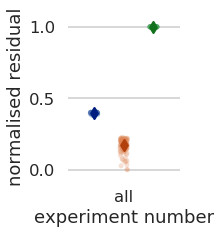

In [69]:
sns.set_context("talk")
sns.set_style("whitegrid")

mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14

f, ax = plt.subplots(figsize=(2, 3))
sns.despine(bottom=True, left=True)

sns.stripplot(x='exp', y='normalised', hue='model', data=eps, 
              dodge=True, jitter=True, alpha=.25, zorder=1,
              palette='deep', ax=ax)

sns.pointplot(x="exp", y="normalised", hue="model",
              data=eps,
              estimator=np.median,
              dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

ax.get_legend().remove()
ax.set_xlabel('experiment number')
ax.set_ylabel('normalised residual')

In [70]:
#f.savefig('figures/ito/eps_all_stripplot.pdf')

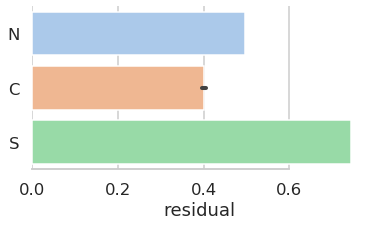

In [72]:
sns.set_context('talk')

f, ax = plt.subplots(figsize=(6,3))

sns.barplot(x="eps", y="model", data=eps, palette='pastel')

ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set(xlabel="residual")
sns.despine(trim=True, left=True)

In [73]:
#f.savefig('figures/ito/eps_all_barplot.pdf')

Below we sample from the posterior particle populations and run the calibration experiments to be able to calculate a per-experiment epsilon value.

In [74]:
N = 100

nyg_par_samples = df_nyg_unified.sample(n=N, weights=w_nyg_unified, replace=True)
nyg_par_samples = nyg_par_samples.set_index([pd.Index(range(N))])
nyg_par_samples = nyg_par_samples.to_dict(orient='records')

cou_par_samples_a_original = df_cou_a_original.sample(n=100, weights=w_cou_a_original, replace=True)
cou_par_samples_a_original = cou_par_samples_a_original.set_index([pd.Index(range(100))])
cou_par_samples_a_original = cou_par_samples_a_original.to_dict(orient='records')

cou_par_samples_i_original = df_cou_i_original.sample(n=100, weights=w_cou_i_original, replace=True)
cou_par_samples_i_original = cou_par_samples_i_original.set_index([pd.Index(range(100))])
cou_par_samples_i_original = cou_par_samples_i_original.to_dict(orient='records')

std_par_samples = df_sta.sample(n=N, weights=w_sta, replace=True)
std_par_samples = std_par_samples.set_index([pd.Index(range(N))])
std_par_samples = std_par_samples.to_dict(orient='records')

In [75]:
from ionchannelABC.experiment import setup
from ionchannelABC.distance import IonChannelDistance

from experiments.ito_wang import (wang_act,
                                  wang_inact)
from experiments.ito_courtemanche import (courtemanche_act_kin,
                                          courtemanche_inact_kin,
                                          courtemanche_deact,
                                          courtemanche_rec)
experiments = [wang_act,
               courtemanche_act_kin,
               courtemanche_deact,
               wang_inact,
               courtemanche_inact_kin,
               courtemanche_rec]
models = ['models/nygren_ito_temp_adj.mmt',
          'models/courtemanche_ito_temp_adj.mmt',
          'models/standardised_ito.mmt']
pars = [nyg_par_samples, [cou_par_samples_a_original, cou_par_samples_i_original], std_par_samples]
names = ['N','C','S']

In [76]:
def experiment_dist(pars, modelfile, experiment):
    eps = []
    observ, model, sum_stats = setup(modelfile,
                                     experiment)
    obs = observ.to_dict()['y']
    obs = {str(k): v for k, v in obs.items()}
    dist = IonChannelDistance(exp_id=list(observ.exp_id),
                              variance=list(observ.variance),
                              delta=0.05)
    for sample in pars:
        eps.append(dist(sum_stats(model(sample)), obs, None))    
    return eps

__The below cell calculates the per-experiment distance and may take some time to run depending on number of samples.__

In [77]:
df = pd.DataFrame({})
mask = [None, [0, 0, 0, 1, 1, 1], None]
for j, exp in enumerate(experiments):
    df_ = pd.DataFrame({})
    for i, m in enumerate(models):
        if mask[i] is not None:
            eps = np.array(
                experiment_dist(pars[i][mask[i][j]],
                                m,
                                exp)
                )
        else:
            eps = np.array(
                experiment_dist(pars[i],
                                m,
                                exp)
                )
        df_ = df_.append(pd.DataFrame({'model': names[i],
                                       'exp': str(j),
                                       'eps': eps[~np.isinf(eps)]}))
    eps_max = df_['eps'].max()
    eps_min = df_['eps'].min()
    df_['eps'] = (df_['eps'] - eps_min)/(eps_max-eps_min)
    df = df.append(df_)

Text(0, 0.5, 'normalised residual')

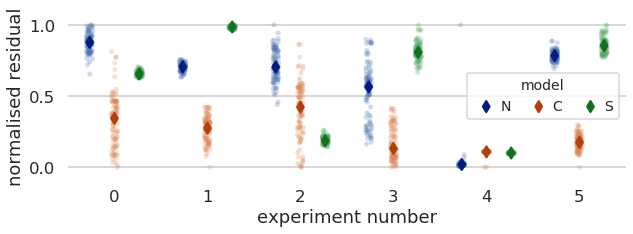

In [79]:
sns.set_context('talk')
sns.set_style('whitegrid')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

fig, ax = plt.subplots(figsize=(10, 3))
sns.despine(bottom=True, left=True)

sns.stripplot(x='exp', y='eps', hue='model', data=df, 
              dodge=True, jitter=True, alpha=.25, zorder=1,
              palette='deep', ax=ax)

sns.pointplot(x="exp", y="eps", hue="model",
              data=df,
              estimator=np.median,
              dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:], labels[3:], title="model",
          handletextpad=0, columnspacing=1,
          loc="best", ncol=3, frameon=True)
ax.set_xlabel('experiment number')
ax.set_ylabel('normalised residual')

In [80]:
#fig.savefig('figures/ito/eps_per_exp_stripplot.pdf')

### Summary statistics compared to experimental data

In [81]:
from ionchannelABC.visualization import plot_sim_results

In [82]:
from experiments.ito_wang import (wang_act,
                                    wang_inact)
from experiments.ito_courtemanche import (courtemanche_act_kin,
                                          courtemanche_inact_kin,
                                            courtemanche_deact,
                                            courtemanche_rec)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:137: RuntimeWarning: invalid value encountered in true_divide


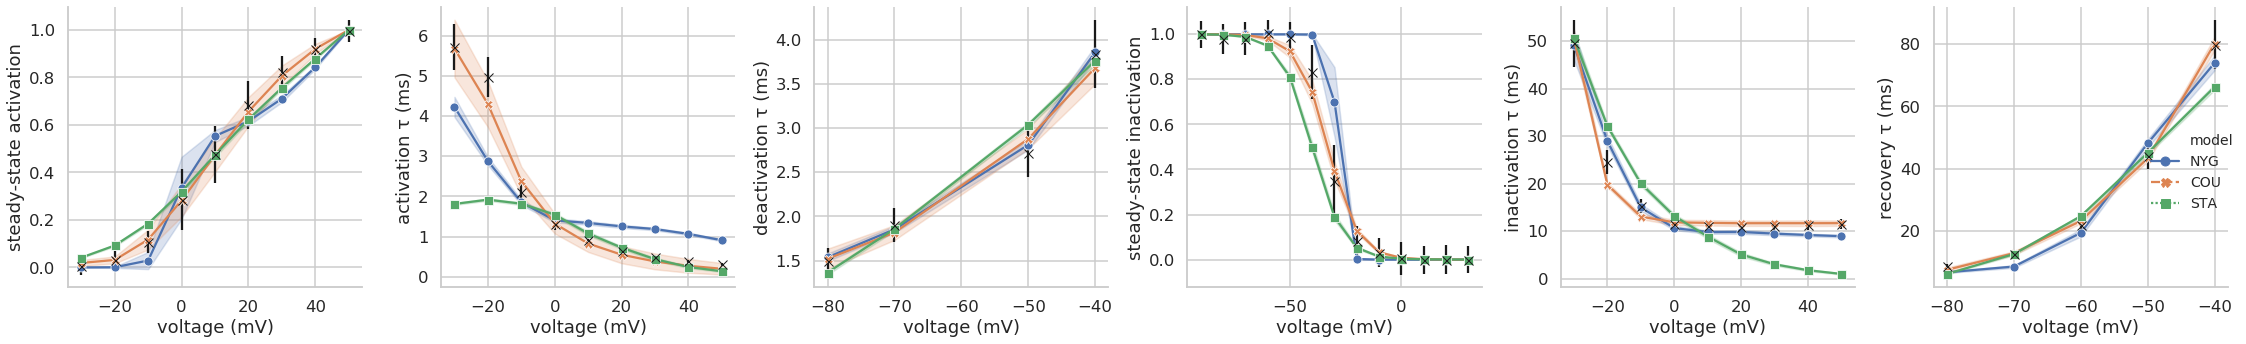

In [83]:
sns.set(style='ticks')
sns.set_context('talk')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(['models/nygren_ito.mmt',
                      'models/courtemanche_ito.mmt',
                      'models/courtemanche_ito.mmt',
                      'models/standardised_ito.mmt'],
                     wang_act,
                     courtemanche_act_kin,
                     courtemanche_deact,
                     wang_inact,
                     courtemanche_inact_kin,
                     courtemanche_rec,
                     temp_match_model = 3,
                     masks=[None,
                            [0,1,2]+[None,]*3,
                            [None,]*3+[3,4,5],
                            None],
                     df=[df_nyg_unified,
                         df_cou_a_original,
                         df_cou_i_original,
                         df_sta], 
                     w=[w_nyg_unified,
                        w_cou_a_original,
                        w_cou_i_original,
                        w_sta])

ylabels = ["steady-state activation", "activation τ (ms)", "deactivation τ (ms)", "steady-state inactivation",
           "inactivation τ (ms)", "recovery τ (ms)"]
for ax in g.axes.flatten():
    ax.set_xlabel("voltage (mV)")
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)
for ax in g.axes.flatten():
    ax.set_title("")

plt.tight_layout()

In [84]:
#g.savefig('figures/ito/compare_summary_statistics.pdf')

### Gating functions compared between models

In [85]:
nyg = 'models/nygren_ito_temp_adj.mmt'
cou ='models/courtemanche_ito_temp_adj.mmt'
std = 'models/standardised_ito.mmt'

In [86]:
v = np.arange(-80, 50, 0.5)

In [87]:
std_par_map = {'ri': 'ito.r_ss',
               'si': 'ito.s_ss',
               'rt': 'ito.tau_r',
               'st': 'ito.tau_s'}

In [88]:
N = 100

nyg_par_samples = df_nyg_unified.sample(n=N, weights=w_nyg_unified, replace=True)
nyg_par_samples = nyg_par_samples.set_index([pd.Index(range(N))])
nyg_par_samples = nyg_par_samples.to_dict(orient='records')

cou_par_samples_a_original = df_cou_a_original.sample(n=100, weights=w_cou_a_original, replace=True)
cou_par_samples_a_original = cou_par_samples_a_original.set_index([pd.Index(range(100))])
cou_par_samples_i_original = df_cou_i_original.sample(n=100, weights=w_cou_i_original, replace=True)
cou_par_samples_i_original = cou_par_samples_i_original.set_index([pd.Index(range(100))])
cou_par_samples = (pd.concat([cou_par_samples_a_original,
                              cou_par_samples_i_original],axis=1)
                   .to_dict(orient='records'))

std_par_samples = df_sta.sample(n=N, weights=w_sta, replace=True)
std_par_samples = std_par_samples.set_index([pd.Index(range(N))])
std_par_samples = std_par_samples.to_dict(orient='records')

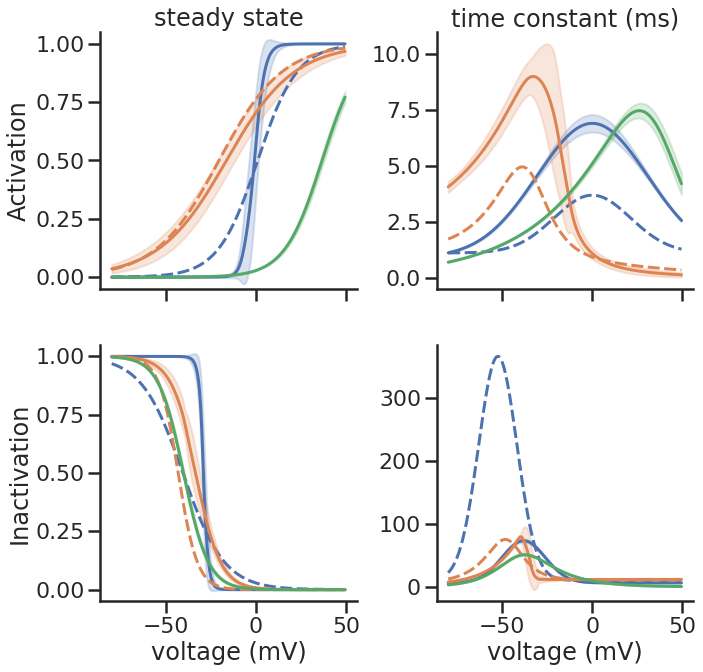

In [94]:
sns.set(style='ticks')
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(v, [nyg_par_map, cou_par_map, std_par_map], 
                       [nyg, cou, std], 
                       [nyg_par_samples, cou_par_samples, std_par_samples],
                       original=[True, True, False],
                       figshape=(2,2))

ax[0][0].set_title('steady state')
ax[0][1].set_title('time constant (ms)')
ax[0][0].set_ylabel('Activation')
ax[1][0].set_ylabel('Inactivation')

for a in ax[:,0]:
    a.set_ylim((-0.05, 1.05))

for a in ax[:,1]:
    a.set_ylabel('')
    
for a in ax[1,:]:
    a.set_xlabel('voltage (mV)')
    
for a in ax.flatten():
    x0,x1 = a.get_xlim()
    y0,y1 = a.get_ylim()
    a.set_aspect(abs(x1-x0)/abs(y1-y0))
    
plt.tight_layout()

In [95]:
#f.savefig('figures/ito/compare_gating_functions.pdf')

### Compare final pulse after pulse train

In [96]:
import myokit

In [97]:
nsteps = 100
period = 1000
tstep = 100
vhold = -50
vstep = -10

pulsetrain = myokit.pacing.steptrain([vstep,]*nsteps,
                                     vhold,
                                     period-tstep,
                                     tstep)

In [98]:
# nygren_ina_full has had tau values adjusted for temperature to 310K
models = [myokit.load_model(modelfile) for modelfile in ['models/nygren_ito_temp_adj.mmt',
                                                         'models/courtemanche_ito_adj.mmt',
                                                         'models/standardised_ito.mmt']]
for m in models:
    pace = m.get('membrane.V')
    if pace.binding() != 'pace':
        if pace.is_state():
            pace.demote()
        pace.set_rhs(0)
        pace.set_binding('pace')

In [99]:
sims = [myokit.Simulation(m, pulsetrain) for m in models]

In [100]:
par_samples = [nyg_par_samples, cou_par_samples, std_par_samples]

In [101]:
import time

all_samples = pd.DataFrame({})
for i, s in enumerate(sims):
    s.reset()
    # store original
    if models[i].name() != 'STA':
        datalog = s.run(pulsetrain.characteristic_time(),
                        log=['ito.g','engine.time','membrane.V'],
                        log_interval=1)
        datalog = datalog.trim((nsteps)*period-tstep-20, (nsteps)*period, adjust=True)
        df = {'time': datalog['engine.time'],
              'gate': datalog.npview()['ito.g']/max(datalog['ito.g']),
              'sample': 0,
              'model': models[i].name(),
              'type': 'original'}
        df = pd.DataFrame(df)
        all_samples = all_samples.append(df, ignore_index=True)
    
    # re-calibrated
    for j, par_sample in enumerate(par_samples[i]):
        s.reset()
        for p, v in par_sample.items():
            name = p
            value = v
            if p.startswith("log"):
                name = p[4:]
                value = 10**v
            s.set_constant(name, value)
            
        # Log run time for comparisons
        t0 = time.time()
        datalog = s.run(pulsetrain.characteristic_time(),
                        log=['ito.g','engine.time','membrane.V'],
                        log_interval=1)
        t1 = time.time()
        dt = t1-t0
        
        datalog = datalog.trim((nsteps)*period-tstep-20, (nsteps)*period, adjust=True)
        df = {'time': datalog['engine.time'],
              'gate': datalog.npview()['ito.g']/max(datalog['ito.g']),
              'sample': j,
              'model': models[i].name(),
              'type': 'recalibrated',
              'runtime': dt}
        df = pd.DataFrame(df)
        all_samples = all_samples.append(df, ignore_index=True)

In [102]:
recalibrated_df = all_samples[all_samples['type']=='recalibrated']

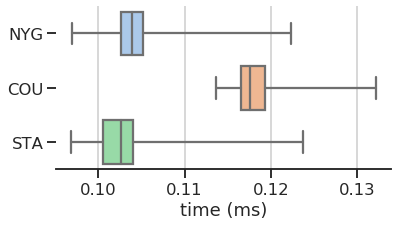

In [103]:
sns.set(style="ticks")
sns.set_context('talk')

# Initialize the figure
f, ax = plt.subplots(figsize=(6, 3))

sns.boxplot(x='runtime', y='model', data=recalibrated_df,
            palette="pastel", whis="range")

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set(xlabel="time (ms)")
sns.despine(left=True)

In [104]:
#f.savefig('figures/ito/runtime_compare.pdf')

In [105]:
all_samples_detail = all_samples[(all_samples['time']>=19) & (all_samples['time'] < 30)]

Text(0.5, 1.0, '')

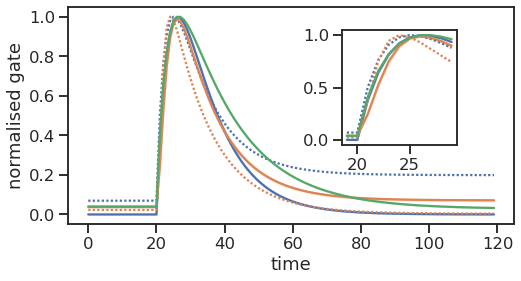

In [106]:
sns.set_context('talk')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plt.subplots(figsize=(8,4))

g = sns.lineplot(x='time', y='gate', hue='model', style='type',
                 dashes = [(1,1),''],
                 data=all_samples, ax=ax,
                 legend=False)


ax2 = plt.axes([.6, .4, .2, .4])
sns.lineplot(x='time',y='gate',hue='model',style='type',
             dashes=[(1,1),''],
             data=all_samples_detail, ax=ax2,
             legend=False)
ax2.set_xlabel('')
ax2.set_ylabel('')

ax.set_ylabel('normalised gate')
ax.set_title('')

In [107]:
#f.savefig('figures/ito/trace_compare.pdf')